In [ ]:
df1_train['intr_12'] = pd.to_numeric(df1_train['intr_12'].replace({'Y': 1}))
df1_train['intr_13'] = pd.to_numeric(df1_train['intr_13'].replace({'Y': 1}))

In [224]:
import pandas as pd
import numpy as np

file1_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file1.csv'
file2_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file2.csv'
file3_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file3.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
df3 = pd.read_csv(file3_path)

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()

df1.set_index('srno_2', inplace=True)
df2.set_index('srno_2', inplace=True)
df3.set_index('srno_2', inplace=True)

df2['YN_Web_Active'] = df2['YN_Web_Active'].replace({'Y': 1, np.nan: 0}).astype(int)
df2['YN_secur'] = df2['YN_secur'].replace({'Y': 1, np.nan: 0}).astype(int)

C:\Users\USER\AppData\Local\Temp\ipykernel_23572\3223945867.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['YN_Web_Active'] = df2['YN_Web_Active'].replace({'Y': 1, np.nan: 0}).astype(int)
C:\Users\USER\AppData\Local\Temp\ipykernel_23572\3223945867.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['YN_secur'] = df2['YN_secur'].replace({'Y': 1, np.nan: 0}).astype(int)


## EDA in file1,file2

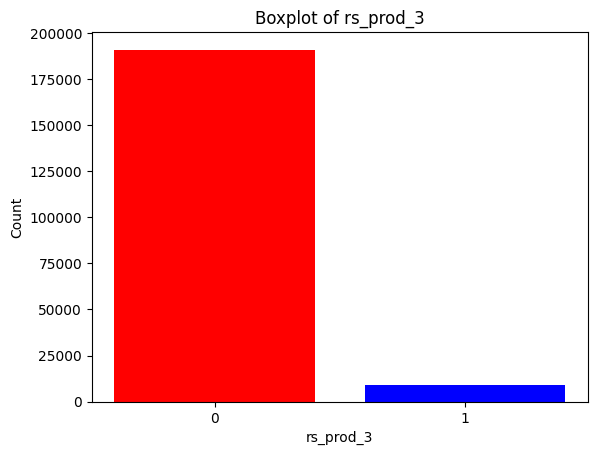

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns


#Target distribution
counts = df3["rs_prod_3"].value_counts()

# 绘制箱线图
plt.bar(counts.index, counts.values,color =  ['r', 'b'])

# 添加标题和标签
plt.title("Boxplot of rs_prod_3")
plt.xlabel("rs_prod_3")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])


plt.show()

#Ubalance data, 我們考慮weighted 抽樣使 train， test set 一致

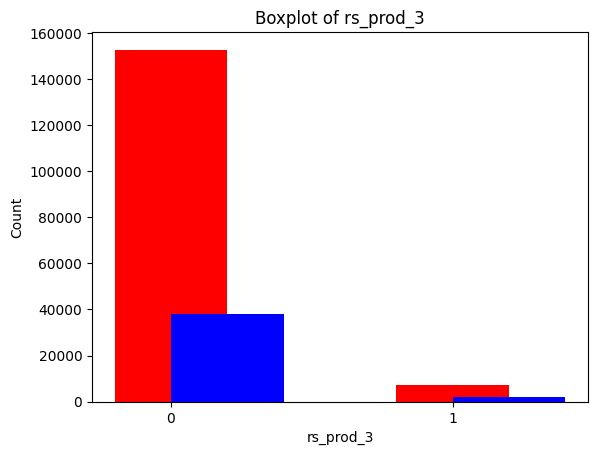

In [228]:
from sklearn.model_selection import train_test_split

X = df3.index
y = df3['rs_prod_3']  

train_index, test_index, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#確保我們的trian set， test set分佈一致
counts_train = y_train.value_counts()

counts_test = y_test.value_counts()

x = range(len(counts_train))
# 绘制箱线图
plt.bar(x, counts_train, width=0.4, label='Train', color='r', align='center')
plt.bar(x, counts_test, width=0.4, label='Test', color='b', align='edge')


# 添加标题和标签
plt.title("Boxplot of rs_prod_3")
plt.xlabel("rs_prod_3")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])


plt.show()

#根據index，拆分df，所有的model train只會在train中
# 切割训练集
df1_train = df1[df1.index.isin(train_index)]
df2_train = df2[df2.index.isin(train_index)]
df3_train = df3[df3.index.isin(train_index)]

# 切割测试集
df1_test = df1[df1.index.isin(test_index)]
df2_test = df2[df2.index.isin(test_index)]
df3_test = df3[df3.index.isin(test_index)]


+ rs_prod   這個人每個月有沒有買

    + rs_prod_df3 這個人有沒有買

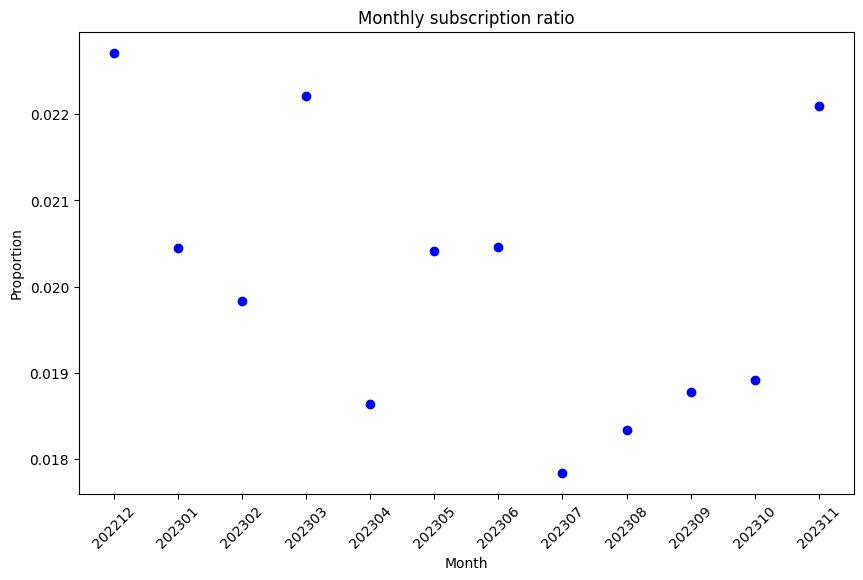

In [229]:
#每個月的申購比例
counts_df = df2_train.groupby("yyyymm")["rs_prod_3"].value_counts().unstack().fillna(0)
proportions_df = counts_df.div(counts_df.sum(axis=1), axis=0)

# Plot the boxplot
plt.figure(figsize=(10, 6))
plt.scatter(proportions_df.index.astype(str), proportions_df[1], marker='o', color='b')
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.title("Monthly subscription ratio")
plt.xticks(rotation=45)
plt.show()

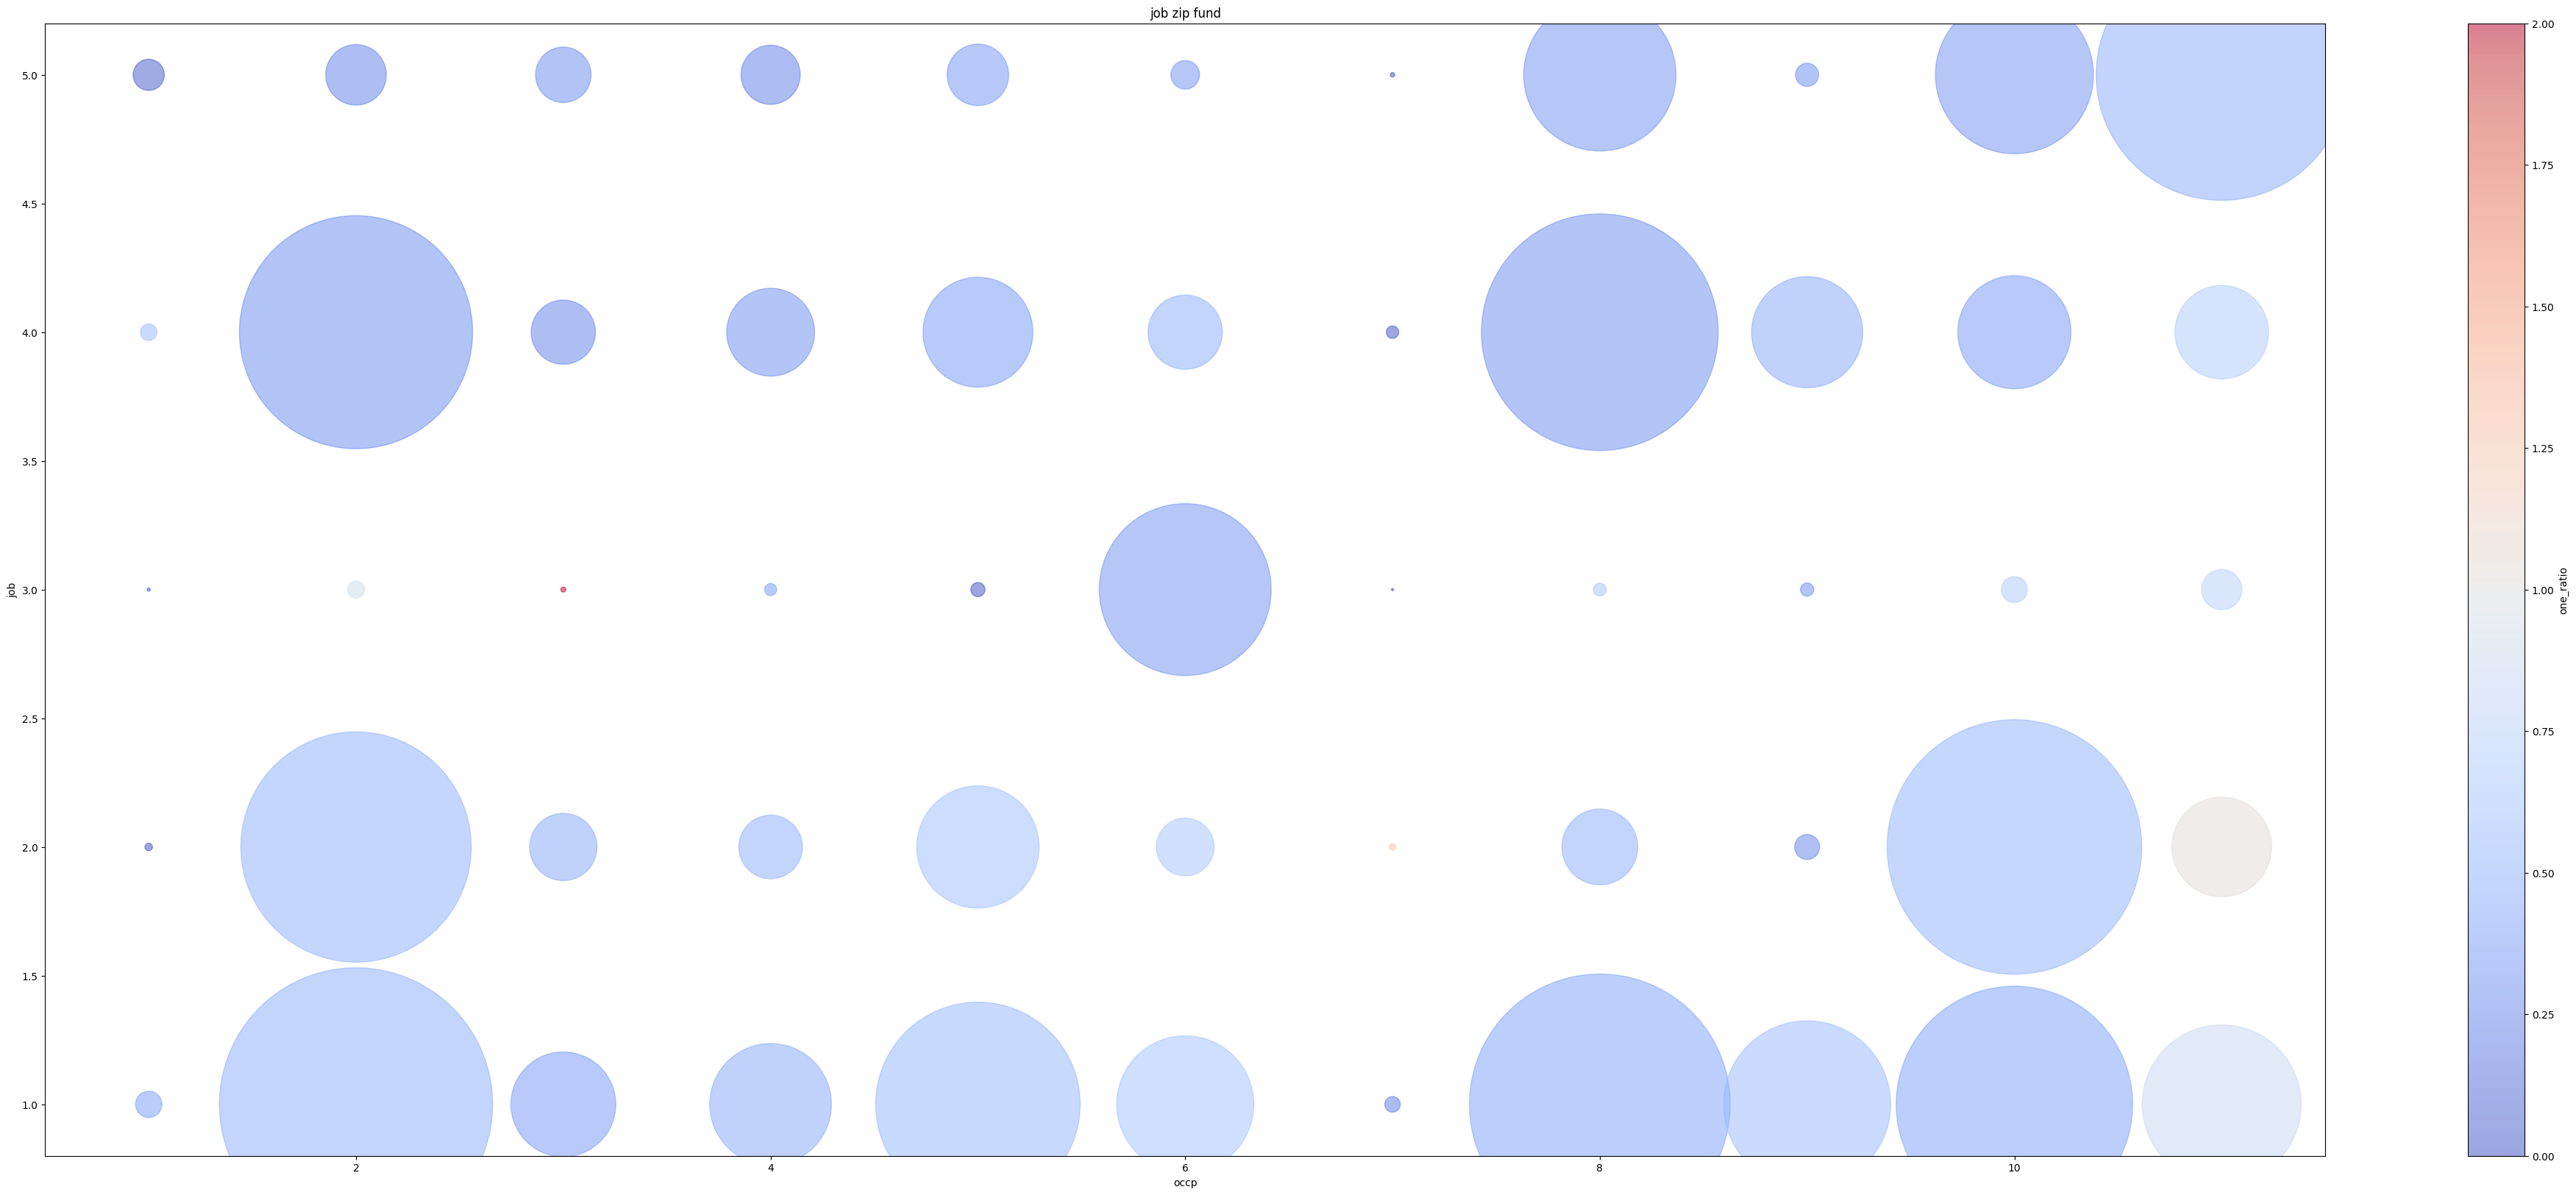

In [230]:
df1_train = pd.merge(df1_train, df3_train['rs_prod_3'], on='srno_2', how='left')
grouped = df1_train.groupby(['job', 'occp'])['rs_prod_3'].agg(['size', lambda x: (x == 1).sum()])

# 计算比例
grouped['one_count'] = grouped["<lambda_0>"]
grouped['one_ratio'] = grouped['one_count'] / grouped['size']

# 获取 x 和 y 的值
x = grouped.index.get_level_values('occp')
y = grouped.index.get_level_values('job')

# 获取每个组的大小和颜色
sizes = grouped['size'].values*5
colors = grouped['one_ratio'].values*10

plt.figure(figsize=(50, 20))

# 绘制散点图，点的大小由 'sizes' 决定，颜色由 'colors' 决定
scatter = plt.scatter(x, y, s=sizes, c=colors, cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter, label='one_ratio')
plt.xlabel("occp")
plt.ylabel("job")
plt.title("job zip fund")
plt.show()

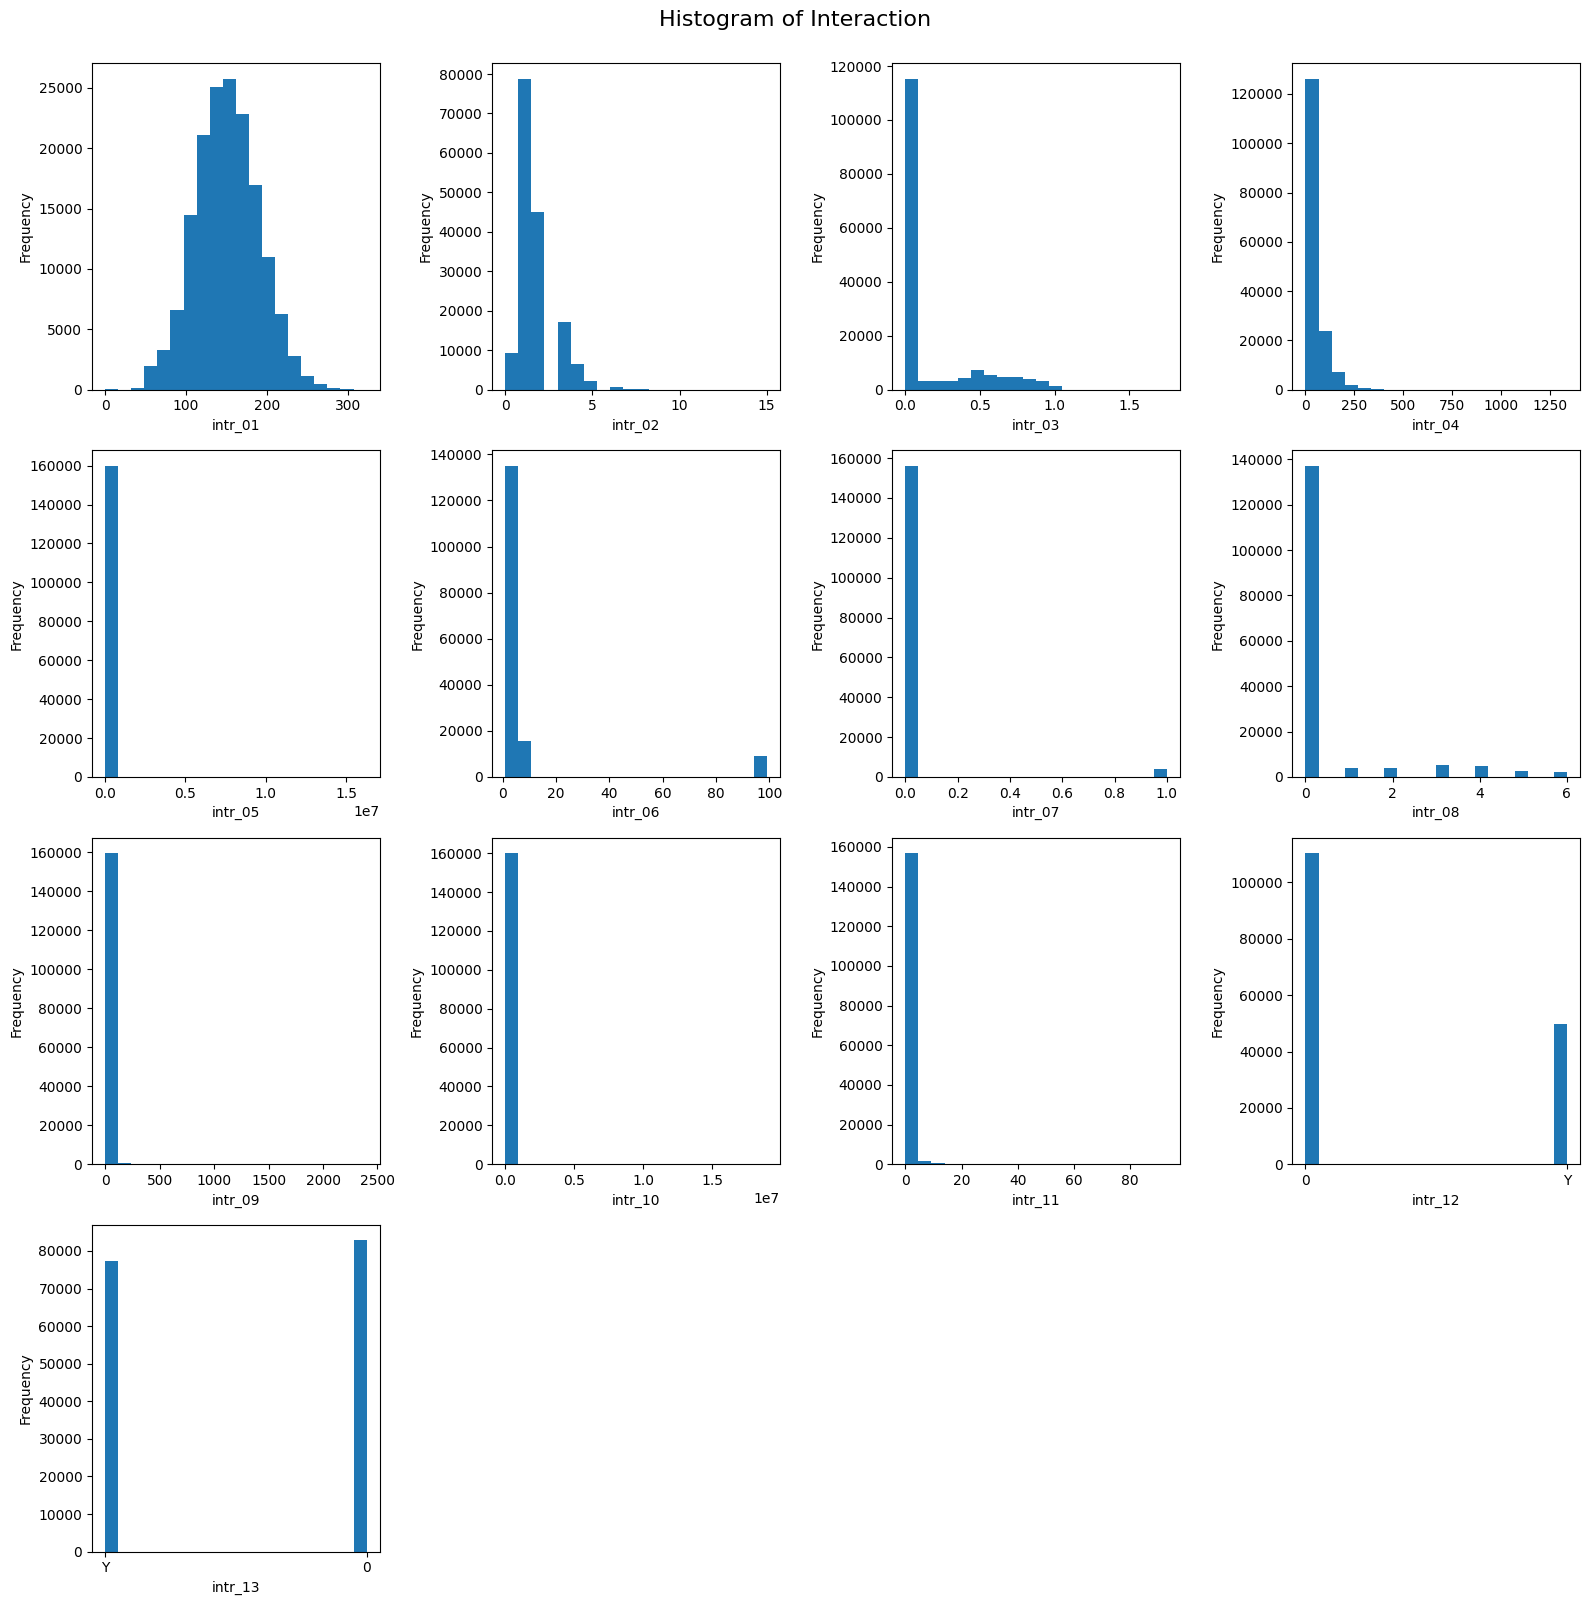

In [231]:
intr_columns = [col for col in df1_train.columns if col.startswith("intr_")]

num_rows = 4
num_cols = 4

plt.figure(figsize=(16, 16))

for i, column in enumerate(intr_columns):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(df1_train[column], bins=20)  
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.suptitle("Histogram of Interaction", fontsize=16, y=1)
plt.tight_layout() 
plt.show()

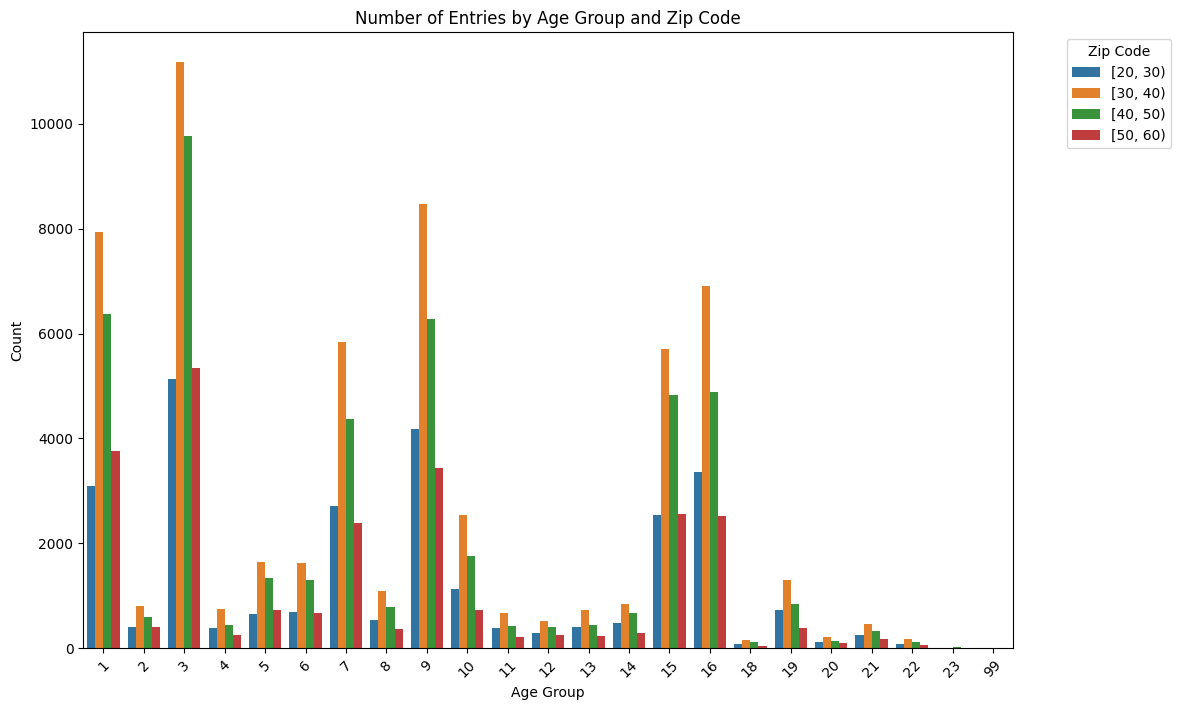

In [232]:
df1_train['age_group'] = pd.cut(df1_train['age'], bins=range(20,df1_train['age'].max()+10, 10), right=False)
#df1_train = df1_train.drop(columns=['rs_prod_3'])
# 统计每个分组的数量
age_group_counts = df1_train['age_group'].value_counts().sort_index()

# 将区间转换为字符串
age_groups_str = [str(interval) for interval in age_group_counts.index]

group_counts = df1_train.groupby(['age_group', 'zip'], observed=False).size().reset_index(name='count')

# 使用 Seaborn 绘制条形图
plt.figure(figsize=(12, 8))
sns.barplot(x='zip', y='count', hue='age_group', data= group_counts)
plt.title('Number of Entries by Age Group and Zip Code')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Zip Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#df1_train = df1_train.drop(columns="age_group")

## EDA IN fILE 2

In [233]:
sub_dataframes = [group for _, group in df2_train.groupby(pd.to_datetime(df2_train['yyyymm'], format='%Y%m').dt.to_period('M'))]
sub_dataframes[0]

,yyyymm,aum01,aum02,aum03,aum04,aum05,aum06,aum07,aum08,aum09,...,CNT_Exchange_A,CNT_Exchange_B,YN_Web_Active,YN_secur,CNT_WBMB_Login,YN_SLR,INV_ADV,rs_prod_1,rs_prod_2,rs_prod_3
srno_2,,,,,,,,,,,,,,,,,,,,,
1,202212,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,0,0
2,202212,467,467,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,0,0
3,202212,34,34,0,0,0,0,0,0,0,...,0,0,1,0,0,NaN,0,0,0,0
4,202212,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,0,0
5,202212,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199996,202212,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,0,1
199997,202212,14,14,0,0,0,0,0,0,0,...,0,0,1,0,0,NaN,0,0,0,0
199998,202212,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,0,0


In [234]:
data_dict = {
    'aum': [],
    'bill': [],
    'pmt_a': [],
    'pmt_c': [],
    'dep': []
}

# 遍历 DataFrame 列表，并对每个类别执行操作
for df in sub_dataframes:
    for category in data_dict.keys():
        # 找到包含特定文本的列
        selected_columns = df[[col for col in df.columns if category in col]]
        # 计算这些列的和
        df[f"{category}_sum"] = np.sum(selected_columns, axis=1)
        # 将结果添加到对应的列表中
        data_dict[category].append(selected_columns)

# 现在 data_dict 中包含了所有的数据
aum, bill, pmt_a, pmt_c, dep = data_dict.values()

df2_cat = {
    'aum': aum,
    'bill': bill,
    'pmt_a': pmt_a,
    'pmt_c': pmt_c,
    'dep': dep
}

In [235]:
def diff_df(df1,df2):
    df = df1.values - df2.values
    df = pd.DataFrame(df,columns = df1.columns )
    return df


df2_diff = {}

for category, data_list in df2_cat.items():
    # 计算每个列表中连续 DataFrame 的差异
    df2_diff[category] = [diff_df(df1, df2) for df1, df2 in zip(data_list[:-1], data_list[1:])]

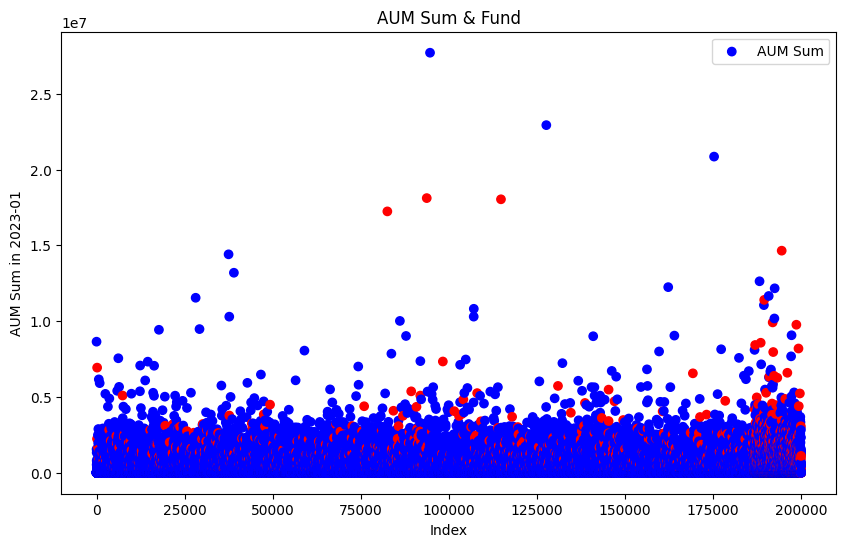

In [236]:
colors = sub_dataframes[1]["rs_prod_3"].map({0: 'blue', 1: 'red'})  # 将 0 映射为蓝色，1 映射为红色

plt.figure(figsize=(10, 6))
plt.scatter(df2_cat["aum"][1].index, df2_cat["aum"][1]["aum01"], c=colors, label='AUM Sum')
plt.title('AUM Sum & Fund')
plt.xlabel('Index')
plt.ylabel('AUM Sum in 2023-01')
plt.legend()
plt.show()

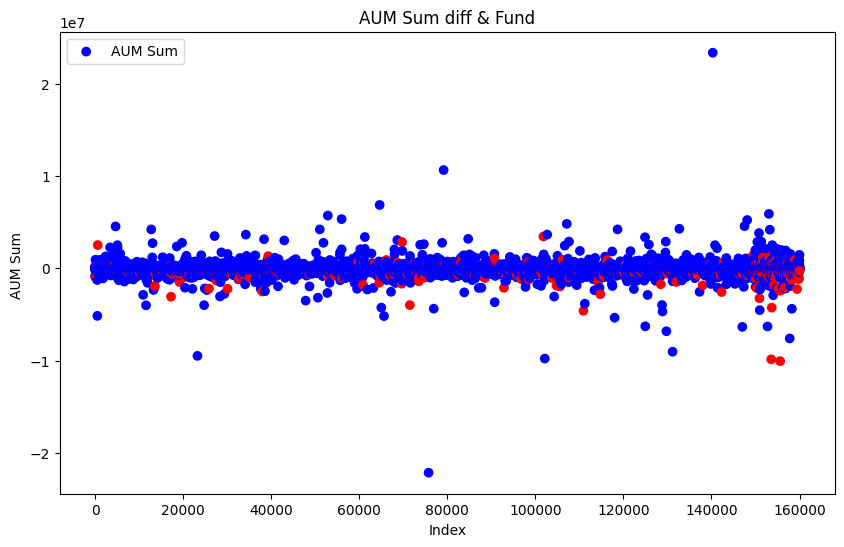

In [237]:
colors = sub_dataframes[1]["rs_prod_3"].map({0: 'blue', 1: 'red'})  # 将 0 映射为蓝色，1 映射为红色

plt.figure(figsize=(10, 6))
plt.scatter(df2_diff["aum"][0].index, df2_diff["aum"][0]["aum01"], c=colors, label='AUM Sum')
plt.title('AUM Sum diff & Fund')
plt.xlabel('Index')
plt.ylabel('AUM Sum ')
plt.legend()
plt.show()

## XGboost only df1 without interaction


In [162]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

X_base = df1_train.drop(columns=intr_columns)
month_auc_scores = []
month_import_features = []
model = XGBClassifier()



for sub_data in sub_dataframes:
    y = pd.DataFrame(sub_data["rs_prod_3"])
    
    feature_importances = pd.DataFrame(index=X.columns)
    fold_auc_scores = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(X_base, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
        model.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = model.predict_proba(X_test)[:, 1] 
        auc = roc_auc_score(y_test, y_pred_proba)
        fold_auc_scores.append(auc)
        
        # 存储特征重要性
        feature_importances['Fold_{}'.format(fold)] = model.feature_importances_
        
    # 计算折叠的平均 AUC
    month_auc = np.mean(fold_auc_scores)
    mean_feature_importances = feature_importances.mean(axis=1)
    month_auc_scores.append(month_auc)
    month_import_features.append(mean_feature_importances)



In [163]:
print(month_auc_scores)

[0.5900519856951373, 0.59684255541805, 0.5810903630838704, 0.597002548084155, 0.5811843244592496, 0.5758100494072773, 0.5684784816064556, 0.5779175083133428, 0.5803080798933541, 0.581922656227656, 0.5822525378227051, 0.5793543509257018]


C:\Users\USER\AppData\Local\Temp\ipykernel_23572\2077542532.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(range(len(idxs)), mean_feature_importances[idxs], align='center')


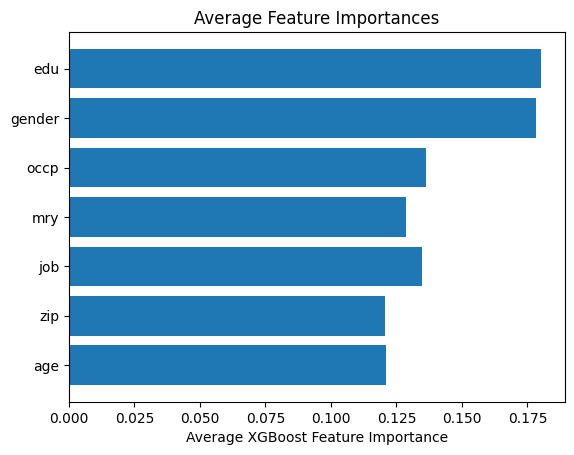

In [161]:

# Sort mean feature importances indices
idxs = np.argsort(month_import_features[0])[-20:]

# Set title
plt.title('Average Feature Importances')

# Create horizontal bar plot
plt.barh(range(len(idxs)), mean_feature_importances[idxs], align='center')

# y-axis labels
plt.yticks(range(len(idxs)), [mean_feature_importances.index[i] for i in idxs])

# x-axis label
plt.xlabel('Average XGBoost Feature Importance')

plt.show()

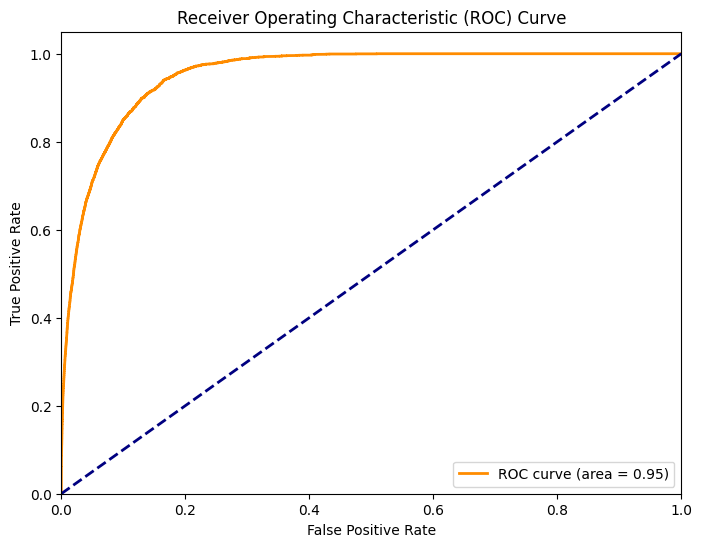

In [146]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict_proba(X_train_resampled)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_pred_proba)

roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost expand with df2

In [ ]:
X_base = X_base.drop(columns= ["rs_prod_3"])

In [273]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
df1_train['intr_12'] = pd.to_numeric(df1_train['intr_12'].replace({'Y': 1}))
df1_train['intr_13'] = pd.to_numeric(df1_train['intr_13'].replace({'Y': 1}))
df1_train['age_group'] = pd.Categorical(df1_train['age_group'])
df1_train['age_group'] = df1_train['age_group'].cat.codes + 1

month_auc_scores = []
month_import_features = []
model = XGBClassifier()


for sub_data in sub_dataframes:
    y = pd.DataFrame(sub_data["rs_prod_3"])
    X_expand = sub_data.drop(columns= ["yyyymm","YN_SLR","rs_prod_3","rs_prod_2","rs_prod_1"])
    X = pd.merge(X_expand,X_base,left_index=True, right_index=True)
    feature_importances = pd.DataFrame(index=X.columns)
    fold_auc_scores = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
        model.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = model.predict_proba(X_test)[:, 1] 
        auc = roc_auc_score(y_test, y_pred_proba)
        fold_auc_scores.append(auc)
        
        # 存储特征重要性
        feature_importances['Fold_{}'.format(fold)] = model.feature_importances_
        
    # 计算折叠的平均 AUC
    month_auc = np.mean(fold_auc_scores)
    mean_feature_importances = feature_importances.mean(axis=1)
    month_auc_scores.append(month_auc)
    month_import_features.append(mean_feature_importances)


In [277]:
print(month_auc_scores)

[0.8490540791879019, 0.8465909459503106, 0.8457349907970995, 0.8442279269038655, 0.8305779952031213, 0.8353258323614865, 0.827402995603004, 0.8407080840800593, 0.8367050527895724, 0.8266344860003552, 0.8352360156090866, 0.8508729150964403]


In [274]:
features = []
for df in month_import_features:
    idx = np.argsort(df)[-20:]
    features.append(df.iloc[idx])

In [275]:
features[0]

mry               0.012434
age               0.012507
occp              0.012753
bill_a5           0.013021
bill_a3           0.014045
aum12             0.014260
gender            0.015251
dep_a2            0.016324
dep_c2            0.016482
CNT_WBMB_Login    0.016549
bill_sum          0.016570
dep_c3            0.018932
dep_c4            0.019336
aum_sum           0.021426
edu               0.022142
aum02             0.023273
bill_a6           0.028033
aum03             0.041011
dep_a4            0.049615
dep_sum           0.104968
dtype: float32